In [96]:
%%file RSGraph.py

import random
import graphviz 
from graphviz import Digraph

class RSGraph():
    """
    THIS IS A BASE CLASS
    
    RSGraph is basically the parent class of two types of network graph: BipartiteRSGraph and HierarchicalRSGraph,
    which are to generate a graph to visualize one or multiple reactions.
    The base class RSGraph builds some basic settings of the graph plot.
    
    ATTRIBUTES
    ===========
    rs: ReactionSystem object, pass in the reaction system to be built graph
    top: graphviz Digraph, dot graph to be plotted graph
    default_style: a dictionary with 3 sub-dictionaries of "graph", "node", "edge", default setting of graph
    
    INITIALIZATION
    ===============
    __init__(self, reaction_sys, format="pdf",style=None)
    
    
    INPUTS: 
    ---------------
        reaction_sys: ReactionSystem object, reaction system to build network graph
        format: string, graph format to be expected to show, initilizaed to be "pdf"
        style: a dictionary with 3 sub-dictionaries of "graph", "node", "edge",
                initialized to default_style as follows.
    
    METHODS
    =======
    plot_system(self, method='jupyter', path=""):
        plot the bipartite graph for the whole reaction system
    
    
    EXAMPLE
    ========
    rs = ReactionSystem(reactions)
    graph = RSGraph(rs)
    graph.plot()   # Displays a graph with customized setting on a jupyter notebook without saving to pdf
    
    """
    
    def __init__(self, reaction_sys, format="pdf",style=None):
        self.rs = reaction_sys
        
        self.default_style = {
            'graph': {
                'fontsize': '16',
                'fontcolor': 'white',
                'bgcolor': '#333333',
                'rankdir': 'BT',
                'pad':'1'
            },
            'nodes': {
                'fontname': 'Helvetica',
                'shape': 'octagon',
                'fontcolor': 'white',
                'color': 'white',
                'style': 'filled',
                'fillcolor': 'black',
            },
            'edges': {
                'style': 'dashed',
                'color': 'white',
                'arrowhead': 'open',
                'fontname': 'Courier',
                'fontsize': '12',
                'fontcolor': 'white',
            }
        }
        
        self.initialize_top_graph(format,style)
    
    
    def initialize_top_graph(self, format="pdf", style = None):
        self.top = Digraph(format = format)
        if style == None:
            self.change_style(self.default_style)
        else:
            self.change_style(style)
            
    
    def build_reaction_graph(self, reaction, prefix = "cluster", color = None):
        raise NotImplementedError
        
        
    def change_style(self, style):
        """
        Changes the style of the top graph. Input style should be a dictionary with 3 sub-dictionaries:
        one for graph, one for nodes and one for edges.
        """
        self.top.graph_attr.update(('graph' in self.default_style and self.default_style['graph']) or {})
        self.top.node_attr.update(('nodes' in self.default_style and self.default_style['nodes']) or {})
        self.top.edge_attr.update(('edges' in self.default_style and self.default_style['edges']) or {})
       
    
    def get_random_color(self):
        """
        Generates a random hexadecimal color.
        """
        return '#%02X%02X%02X' % (random.randint(0,255),random.randint(0,255),random.randint(0,255))
         

    def plot(self,method='jupyter',path=""):
        """
        Displays current top graph in jupyter or pdf version. If pdf selected, also saves the image. 
        If no path has been specified, the image is saved in the current directory.
        """
        if method == 'jupyter':
            return self.top
        
        elif method == 'format':
            self.top.view()
        
        else:
            raise ValueError('Unknown method. Valid methods are "jupyter" or "pdf".')
    
    
    def plot_reactions(self, method = 'jupyter', path = "", idxs = []):
        """
        Plots individual graphs for each reaction in the ReactionSystem.
        """
        raise NotImplementedError
        
    def plot_system(self,method='format',path=""):
        """
        Plots the Reaction system as a whole, without separation between reactions. Shows how each specie interacts 
        """
        raise NotImplementedError
        
    def save_evolution_mp4(self,system,reactions,timesteps=5, path = ""):
        raise NotImplementedError
        
    def set_edges(self, reaction, color):
        raise NotImplementedError
        
    def save_mp4(self,imgs, path):
        raise NotImplementedError

        
class BipartiteRSGraph(RSGraph):
    """
    This class generates a graph to visualize the whole reaction system. 
    It builds nodes for both species and id of equation and seperate them into two parts.
    We construct a bipartite graph with species as nodes (u,1) in one side, and reactions as nodes (u,2) in another side. 
    Build directed edges (u,1) to (v,2) if edge u is the reactant of equation v. 
    Build directed edges (u,2) to (v,1) if edge v is the product of equation u. 
    Set edges to be dashed if the equation is reversible, otherwise filled.
    From this graph, we could recompute the reaction equations.
    The graph assigns a color to each equation (can be defined by the user) and can show concentration of a given specie in the set of reactions by size of the node.
    The reactions can be plotted with different grouping options and style options.
    
    METHODS
    =======
    plot_system(self, method='jupyter', path=""):
        plot the bipartite graph for the whole reaction system

    
    EXAMPLES
    ========
    rs = ReactionSystem(reactions)
    b_graph = BipartiteRSGraph(rs)
    b_graph.plot_system(method='jupyter')   # Displays on a jupyter notebook without saving to pdf

    
    """
    
    def plot_system(self, method='jupyter', path=""):
        self.initialize_top_graph()
        
        self.top.graph_attr.update(rankdir='LR')
        
        self.top.graph_attr.update(ranksep='2')
        
        with self.top.subgraph(name='cluster_1') as c:
#             c.attr(label='Reaction', labelloc = 'b')
            c.attr(label='Reaction')
            c.attr(color='white')
            for idx in range(len(self.rs.get_reactions())):
                c.node(str(idx))

        with self.top.subgraph(name='cluster_0') as c:
            c.attr(color='white')
            c.attr(label='Species')
            for s in self.rs.get_species():
                c.node(s)
        
        for idx, r in enumerate(self.rs.get_reactions()):
            c = self.get_random_color()
            if r.is_reversible():
                for k1 in r.getReactants():
                    self.top.edge(k1, str(idx), color = c)
                for k2 in r.getProducts():
                    self.top.edge(str(idx), k2, color = c)
            else:
                for k1 in r.getReactants():
                    self.top.edge(k1, str(idx), color = c, style = "filled")
                for k2 in r.getProducts():
                    self.top.edge(str(idx), k2, color = c, style = "filled")
        
        return self.plot(method=method, path=path)      

Overwriting RSGraph.py


In [41]:
class HierarchicalRSGraph(RSGraph):
    def build_reaction_graph(self, reaction, prefix = "cluster", color = None):
        """
        Builds a graph for one reaction.
        """
        if color == None:
            color = self.get_random_color()
            
        r_graph = Digraph(prefix+'Reaction')
        r_graph.graph_attr.update(label = reaction.get_reaction_equation())
        
        for s in reaction.get_species():
            r_graph.node(s)
            
        self.set_edges(reaction, color)
            
        return r_graph
    
    def plot_reactions(self, method = 'jupyter', path = "", idxs = []):
        """
        Plots individual graphs for each reaction in the ReactionSystem.
        """
        
        if not idxs:
            idxs = range(len(self.rs.get_reactions()))
        for i,r in enumerate(self.rs.get_reactions()):
            if i in idxs:
                r_graph = build_reaction_graph(r,prefix = 'cluster')
                self.top.subgraph(r_graph)
                r_graph.graph_attr.update(rank='same')
        
        self.plot(method = method, path=path)
        
    
    def plot_system(self,method='jupyter',path=""):
        """
        Plots the Reaction system as a whole, without separation between reactions. Shows how each specie interacts 
        In the full reaction system. If the amount of reactions in the system is less than 4, the plot will be generated
        With 2 columns of species, representing on the left the species that are more reactant than product, and on the right
        the species that are more product than reactant. If the system has more than 4 reactions, an automatic organization
        of nodes is performed instead.
        """
        self.initialize_top_graph()
        
        self.top.graph_attr.update(rankdir='LR')
        
        if len(self.rs.get_reactions()) <=4:
            self.top.graph_attr.update(ranksep='2')
            reac = Digraph('Reactant graph')
            prod = Digraph('Product graph')
            reactant_count = {}
            product_count = {}
            for s in self.rs.get_species():
                for r in self.rs.get_reactions():
                    if s in r.getReactants().keys():
                        reactant_count[s]+=1
                    if s in r.getProducts().keys():
                        product_count[s]+=1
            for s in self.rs.get_species():
                if reactant_count[s] == 0:
                    reac.node(s)
                elif product_count[s] == 0:
                    prod.node(s)
                elif reactant_count[s] >= product_count[s]:
                    reac.node(s)
                elif reactant_count[s] < product_count[s]:
                    prod.node(s)
            reac.node_attr.update(rank = 'same')
            prod.node_attr.update(rank = 'same')
            top.subgraph(reac)
            top.subgraph(prod)
            
        else:
            for s in self.rs.get_species():
                self.top.node(s)
        
        for reaction in self.rs.get_reactions():
            color = self.get_random_color()
            self.set_edges(reaction, color)
    
        self.plot(method=method, path=path)
        
        
    def save_evolution_mp4(self,system,reactions,timesteps=5, path = ""):
        
        for n in range(timesteps):
            self.rs.concentration_step()
            imgs.append(self.plot_system())
        
        self.save_gif(imgs)
    
    def set_edges(self, reaction, color):
        for idx, r1 in enumerate(reaction.getReactants().keys()):
            for r2 in reaction.getProducts().keys():
                if reaction.is_reversible():
                    r_graph.edge(r1, r2, arrowhead = 'none', color = color)
                else:
                    r_graph.edge(r1, r2, color = color)
            for jdx, r2 in enumerate(reaction.getReactants().keys()):
                if r1 != r2 and jdx > idx:
                    top.edge(k1, k2, arrowhead = 'none', color = color, style = 'filled') 
                    
    def save_mp4(self,imgs, path):
        frames = [ImageClip(img).set_duration(0.1) for img in imgs]
        movie = concatenate_videoclips(frames, method="compose")
        movie.write_videofile(path+".mp4", fps=30)


In [52]:
dot = RSGraph(rs2)
dot.plot(method = "format")

In [43]:
dot_h = HierarchicalRSGraph(rs2)

In [68]:
dot_h.plot_system(method = "jupyter")

NameError: name 'r_graph' is not defined

In [65]:
dot_b = BipartiteRSGraph(rs2)

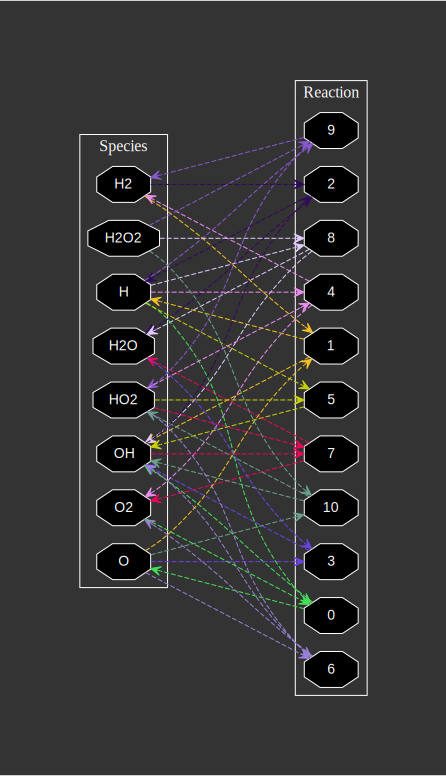

In [66]:
dot_b.plot_system(method = "jupyter")

In [16]:
%%file test_RSGraph.py

# Testing
import os
import sqlite3
from chemkin_CS207_G9.parser.database_query import CoeffQuery
from chemkin_CS207_G9.parser.xml2dict import xml2dict
from chemkin_CS207_G9.reaction.Reaction import Reaction
from chemkin_CS207_G9.reaction.ReactionSystem import ReactionSystem
import chemkin_CS207_G9.data as data_folder
import numpy as np
from RSGraph import RSGraph, BipartiteRSGraph
import graphviz
from graphviz import Digraph

# Paths
BASE_DIR = os.path.dirname(os.path.abspath(data_folder.__file__))
path_xml = os.path.join(BASE_DIR, 'rxns_reversible.xml') # path to the .xml file
path_sql = os.path.join(BASE_DIR, 'nasa_thermo.sqlite')  # path to the .sqlite file

# Loading Reactions and Species from xml file
reader = xml2dict()
reader.parse(path_xml)
info = reader.get_info()
species = info[0]
reactions = [Reaction(**r) for r in info[1]]
cq = CoeffQuery(path_sql)
rs1 = ReactionSystem(reactions[:4], nasa_query = cq)
rs2 = ReactionSystem(reactions, species_ls = species, nasa_query = cq)


def test_RSGraph():
    rs = ReactionSystem(reactions)
    graph = RSGraph(rs)
    graph.plot()

def test_BipartiteGraph():
    rs = ReactionSystem(reactions)
    b_graph = BipartiteRSGraph(rs)
    b_graph.plot_system(method='jupyter')

def test_plot_system_on_notebook():
    h_graph = BipartiteRSGraph(rs1)
    h_graph.plot_system(method = 'jupyter')

def test_plot_system_pdf():
    h_graph = BipartiteRSGraph(rs1)
    h_graph.plot_system(method = 'format')
    
def test_changing_styles():
    h_graph = BipartiteRSGraph(rs1)
    new_style = {
        'graph': {
            'fontsize': '16',
            'fontcolor': 'white',
            'bgcolor': '#333333',
            'rankdir': 'BT',
            'pad':'1'
        },
        'nodes': {
            'fontname': 'Courier',
            'shape': 'circle',
            'fontcolor': 'white',
            'color': 'white',
            'style': 'dashed',
            'fillcolor': 'black',
        },
        'edges': {
            'style': 'bold',
            'color': 'white',
            'arrowhead': 'empty',
            'fontname': 'Courier',
            'fontsize': '12',
            'fontcolor': 'white',
        }
    }
    
    h_graph.change_style(new_style)
    g = h_graph.plot_system()
    assert(type(g)==Digraph)
    g



Overwriting test_RSGraph.py


In [87]:
test_plot_system_on_notebook()

In [89]:
test_plot_system_pdf()

In [15]:
import graphviz
from graphviz import Digraph
Digraph

graphviz.dot.Digraph

In [17]:
!pytest --doctest-modules --cov --cov-report term-missing

============================= test session starts ==============================
platform darwin -- Python 3.6.1, pytest-3.0.7, py-1.4.33, pluggy-0.4.0
rootdir: /Users/gwungwun/cs207-FinalProject, inifile: setup.cfg
plugins: cov-2.5.1
collected 53 items 

test_RSGraph.py .....
chemkin_CS207_G9/auxiliary/check_and_response.py .
chemkin_CS207_G9/auxiliary/mathematical_science.py .
chemkin_CS207_G9/reaction/CoeffLaw.py ...
chemkin_CS207_G9/reaction/Reaction.py ..
test/test_CoeffLaw.py ....
test/test_NonNetworkPlot.py ...
test/test_Reaction.py ........
test/test_ReactionSystem.py .................
test/test_database_query.py ...
test/test_xml2dict.py ......

---------- coverage: platform darwin, python 3.6.1-final-0 -----------
Name                                                                      Stmts   Miss  Cover   Missing
-------------------------------------------------------------------------------------------------------
/Users/gwungwun/.local/lib/python3.6/site-packages/graphvi